In [53]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

In [6]:
df=pd.read_csv('_train_sem09__1_.zip')

In [7]:
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X=df.drop(['Activity'], axis=1)
y=df['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

## <center> **Линейная регрессия**

In [5]:
log_reg=linear_model.LogisticRegression(random_state=42,
                                        max_iter=1000)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


f1_score на тестовом наборе: 0.78


### 1. GridSearchCV

In [21]:
#param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
#              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
#              }
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'],#, # алгоритм оптимизации
              'C': [0.01, 0.1, 0.3, 0.5, 0.8, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.8, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train); 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

CPU times: user 1.38 s, sys: 238 ms, total: 1.62 s
Wall time: 3min 56s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


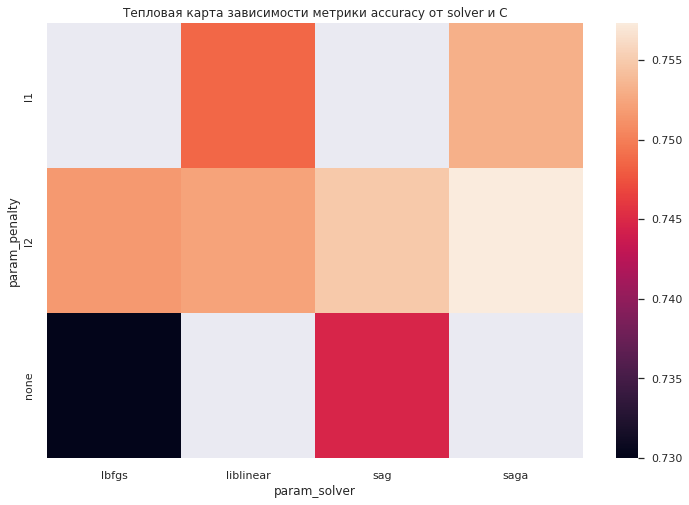

In [22]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_penalty',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

### 2. RandomizedSearchCV

In [23]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    #param_grid=param_grid, 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  



In [24]:
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag

CPU times: user 4.19 s, sys: 249 ms, total: 4.44 s
Wall time: 1min 11s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.34}


/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 3. Hyperopt

In [29]:
type(space['penalty'])

hyperopt.pyll.base.Apply

In [20]:
a.arg.getter

<function property.getter>

In [37]:
space1={'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver':hp.choice('solver',['lbfgs', 'sag']),
       'C': hp.choice('C',[0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.0] )
       }
space = hp.choice('parameter_combinations', [
        {'solver': hp.choice('solver',['liblinear', 'saga']),
         'penalty': hp.choice('penalty', ['l1', 'l2']),
         'C': hp.uniform('C_saga', 0.01, 1)
        },
        
        {'solver': hp.choice('solver1',['lbfgs', 'sag']),
        'penalty': hp.choice('penalty1', ['l2', 'none']),
        'C': hp.uniform('C_lbfgs', 0.01, 1)
        }
        ]
)
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    print(f'params={params}')
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'],'solver': params['solver'],'C': params['C']}
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=50)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


In [38]:
%%time
# начинаем подбор гиперпараметров


trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) 
          #np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

params={'C': 0.8850873592178893, 'penalty': 'l2', 'solver': 'saga'}
params={'C': 0.8623211770943003, 'penalty': 'l2', 'solver': 'lbfgs'}             
  5%|▌         | 1/20 [00:04<01:26,  4.53s/trial, best loss: -0.8634978671541743]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



params={'C': 0.621484242760273, 'penalty': 'l1', 'solver': 'liblinear'}          
 10%|█         | 2/20 [00:05<00:39,  2.18s/trial, best loss: -0.8707607699358387]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



params={'C': 0.5965288791925494, 'penalty': 'l2', 'solver': 'lbfgs'}             
params={'C': 0.2944827566547015, 'penalty': 'l2', 'solver': 'saga'}              
 20%|██        | 4/20 [00:06<00:17,  1.12s/trial, best loss: -0.8707607699358387]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



params={'C': 0.44752396436892883, 'penalty': 'l2', 'solver': 'sag'}              
 25%|██▌       | 5/20 [00:10<00:35,  2.34s/trial, best loss: -0.8707607699358387]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



params={'C': 0.09092947253263425, 'penalty': 'l2', 'solver': 'sag'}              
 30%|███       | 6/20 [00:15<00:42,  3.00s/trial, best loss: -0.8707607699358387]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



params={'C': 0.7505554152307968, 'penalty': 'l2', 'solver': 'liblinear'}         
 35%|███▌      | 7/20 [00:19<00:44,  3.39s/trial, best loss: -0.8707607699358387]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



params={'C': 0.06353709569974215, 'penalty': 'l1', 'solver': 'saga'}             
params={'C': 0.44064797411429824, 'penalty': 'l2', 'solver': 'lbfgs'}            
 45%|████▌     | 9/20 [00:26<00:40,  3.69s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



params={'C': 0.2756415061734322, 'penalty': 'l2', 'solver': 'liblinear'}          
 50%|█████     | 10/20 [00:26<00:27,  2.72s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



params={'C': 0.11378231087600388, 'penalty': 'l2', 'solver': 'sag'}               
params={'C': 0.6130131075974361, 'penalty': 'l1', 'solver': 'liblinear'}          
 60%|██████    | 12/20 [00:31<00:21,  2.73s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



params={'C': 0.09796332958517907, 'penalty': 'none', 'solver': 'lbfgs'}           
 65%|██████▌   | 13/20 [00:32<00:15,  2.15s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



params={'C': 0.02692572304826705, 'penalty': 'l2', 'solver': 'lbfgs'}             
 70%|███████   | 14/20 [00:33<00:10,  1.68s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



params={'C': 0.2122414094900606, 'penalty': 'l1', 'solver': 'saga'}               
 75%|███████▌  | 15/20 [00:33<00:06,  1.33s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



params={'C': 0.8188248165712314, 'penalty': 'none', 'solver': 'sag'}              
 80%|████████  | 16/20 [00:39<00:10,  2.72s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



params={'C': 0.3571764603405996, 'penalty': 'none', 'solver': 'lbfgs'}            
 85%|████████▌ | 17/20 [00:43<00:09,  3.16s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



params={'C': 0.13679612696710813, 'penalty': 'l2', 'solver': 'lbfgs'}             
 90%|█████████ | 18/20 [00:44<00:04,  2.37s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



params={'C': 0.9762398987615277, 'penalty': 'l1', 'solver': 'liblinear'}          
 95%|█████████▌| 19/20 [00:44<00:01,  1.80s/trial, best loss: -0.8814180929095354]

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



100%|██████████| 20/20 [00:45<00:00,  2.30s/trial, best loss: -0.8814180929095354]
Наилучшие значения гиперпараметров {'C_saga': 0.7505554152307968, 'parameter_combinations': 0, 'penalty': 1, 'solver': 0}
CPU times: user 49.3 s, sys: 1.91 s, total: 51.2 s
Wall time: 45.9 s


In [49]:
# Расчет метрики для лучших найденных гиперпараметров 

best_params = {'solver': 'liblinear',
          'penalty': 'l2', 
          'C': 0.7505554152307968
}

# Модель с лучшими параметрами
hyperopt_lr = linear_model.LogisticRegression(**best_params, 
                                   random_state=random_state, max_iter=50
)
hyperopt_lr.fit(X_train, y_train)
y_train_pred = hyperopt_lr.predict(X_train)
y_test_pred = hyperopt_lr.predict(X_test)
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')

F1 на тестовой выборке: 0.7865707434052758


In [50]:
best_params = {'solver': 'saga',
          'penalty': 'l2', 
          'C': 0.10567819922023905
}
hyperopt_lr = linear_model.LogisticRegression(**best_params,
                                   random_state=random_state, max_iter=50
)
hyperopt_lr.fit(X_train, y_train)
y_train_pred = hyperopt_lr.predict(X_train)
y_test_pred = hyperopt_lr.predict(X_test)
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')

F1 на тестовой выборке: 0.7889688249400479


/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 4. Optuna

In [54]:
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])
    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'
    C = trial.suggest_uniform('C', 0.01, 1)
    
    model = linear_model.LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        class_weight='balanced', 
        random_state=random_state, 
        max_iter=50
    )    
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=random_state)
study_lr = optuna.create_study(
    sampler=sampler, study_name='LogisticRegression', direction='maximize')
study_lr.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами
optuna_lr = linear_model.LogisticRegression(
    **study_lr.best_params, class_weight='balanced', n_jobs=-1,
    random_state=random_state, max_iter=50
)
optuna_lr.fit(X_train, y_train)
y_train_pred = optuna_lr.predict(X_train)
y_test_pred = optuna_lr.predict(X_test)

[I 2022-07-14 14:03:15,900] A new study created in memory with name: LogisticRegression
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solve

In [56]:
print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')
print(f'F1 на кросс-валидации: {study_lr.best_value}')
print(f'F1 на тренировочной выборке: {metrics.f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')

Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.6991566253247379}
F1 на кросс-валидации: 0.7776116597991605
F1 на тренировочной выборке: 0.8558979147214442
F1 на тестовой выборке: 0.7769607843137254


## <center> **Случайный лес**

In [62]:
rf=ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


f1_score на тестовом наборе: 0.81


### 1. GridSearchCV

In [63]:
# Сетка параметров
param_grid = [
    
    {'n_estimators': [100, 200, 300],
     'criterion': ['gini', 'entropy'],
     'max_depth': [5, 10, 50],
     'min_samples_leaf': [5, 50]
    }
]

# Поиск по сетке параметров с кросс-валидацией (5 фолдов)
grid_search_rf = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                 random_state=random_state), 
    param_grid=param_grid, 
    scoring = 'f1',
    cv=5, 
    n_jobs = -1
)  
grid_search_rf.fit(X_train, y_train) 
y_train_pred = grid_search_rf.predict(X_train)
y_test_pred = grid_search_rf.predict(X_test)
print(f'F1 на кросс-валидации: {metrics.f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')
print(f'Наилучшие значения гиперпараметров: {grid_search_rf.best_params_}')

F1 на кросс-валидации: 0.954264524103832
F1 на тестовой выборке: 0.8168674698795181
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 200}


### 2. RandomizedSearchCV

In [64]:
# Распределение параметров (в виде неслучайной сетки)
param_distr = [
    
    {'n_estimators': list(range(100, 500, 100)),
     'criterion': ['gini', 'entropy'],
     'max_depth': list(range(1, 100, 5)),
     'min_samples_leaf': list(range(5, 100, 5))
    }
]

# Случайный поиск по распределению параметров с кросс-валидацией (5 фолдов)
random_search_rf = RandomizedSearchCV(
    estimator = ensemble.RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                 random_state=random_state),
    param_distributions=param_distr, 
    scoring = 'f1',
    cv=5,
    n_iter=20, # 20 случайных наборов параметров
    n_jobs = -1
)  
random_search_rf.fit(X_train, y_train) 
y_train_pred = random_search_rf.predict(X_train)
y_test_pred = random_search_rf.predict(X_test)
print(f'F1 на кросс-валидации: {metrics.f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')
print(f'Наилучшие значения гиперпараметров: {random_search_rf.best_params_}')



F1 на кросс-валидации: 0.9081761006289308
F1 на тестовой выборке: 0.8004926108374384
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 5, 'max_depth': 11, 'criterion': 'entropy'}


### 3. Hyperopt

In [65]:
# Пространство параметров 
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
       'criterion': hp.choice('criterion', ['gini', 'entropy']),
       'max_depth' : hp.quniform('max_depth', 1, 100, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 100, 1)
      }


# Целевая функция
def obj_func(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']),
              'criterion': params['criterion'],
              'max_depth': int(params['max_depth']), 
              'min_samples_leaf': int(params['min_samples_leaf'])
             }
  
    model = ensemble.RandomForestClassifier(**params, class_weight='balanced', 
                                   n_jobs=-1, random_state=random_state)
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    
    return -score


trials = Trials()
best=fmin(obj_func, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          #rstate=np.random.RandomState(random_state)
          rstate=np.random.default_rng(random_state)
         )
print(f'Наилучшие значения гиперпараметров: {best}')

100%|██████████| 20/20 [01:34<00:00,  4.73s/trial, best loss: -0.7977672363690356]
Наилучшие значения гиперпараметров: {'criterion': 0, 'max_depth': 28.0, 'min_samples_leaf': 6.0, 'n_estimators': 114.0}


In [66]:
# Расчет метрики для лучших найденных гиперпараметров 

best_score = (np.array(list(x['result']['loss'] 
                            for x in trials.trials)) * (-1)).max()
print(f'F1 на кросс-валидации: {best_score}')

best_params = {
    'n_estimators': int(best['n_estimators']),
    'criterion': 'gini',
    'max_depth': int(best['max_depth']),
    'min_samples_leaf': int(best['min_samples_leaf'])
}

# Модель с лучшими параметрами
hyperopt_rf = ensemble.RandomForestClassifier(**best_params, class_weight='balanced',
                                 n_jobs=-1, random_state=random_state)
hyperopt_rf.fit(X_train, y_train)
y_train_pred = hyperopt_rf.predict(X_train)
y_test_pred = hyperopt_rf.predict(X_test)
print(f'F1 на тренировочной выборке: {metrics.f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')


F1 на кросс-валидации: 0.7977672363690356
F1 на тренировочной выборке: 0.9324240545567265
F1 на тестовой выборке: 0.8068043742405832


### 4. Optuna

In [72]:
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 500, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 1, 100, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, 1)
  
    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced', n_jobs=-1,
        random_state=random_state
    )
  
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=random_state)
study_rf = optuna.create_study(
    sampler=sampler, study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами  
optuna_rf = ensemble.RandomForestClassifier(
    **study_rf.best_params, class_weight='balanced', n_jobs=-1,
    random_state=random_state
)
optuna_rf.fit(X_train, y_train)
y_train_pred = optuna_rf.predict(X_train)
y_test_pred = optuna_rf.predict(X_test)

[I 2022-07-14 15:06:46,924] A new study created in memory with name: RandomForestClassifier
[I 2022-07-14 15:07:13,511] Trial 0 finished with value: 0.7740137242780688 and parameters: {'n_estimators': 250, 'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7740137242780688.
[I 2022-07-14 15:07:16,205] Trial 1 finished with value: 0.7276799339604356 and parameters: {'n_estimators': 162, 'criterion': 'entropy', 'max_depth': 61, 'min_samples_leaf': 72}. Best is trial 0 with value: 0.7740137242780688.
[I 2022-07-14 15:07:18,764] Trial 2 finished with value: 0.7670621294259172 and parameters: {'n_estimators': 108, 'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.7740137242780688.
[I 2022-07-14 15:07:22,793] Trial 3 finished with value: 0.7605692316010346 and parameters: {'n_estimators': 173, 'criterion': 'entropy', 'max_depth': 44, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.7740137242780688.
[I

In [73]:
print(f'Наилучшие значения гиперпараметров: {study_rf.best_params}')
print(f'F1 на кросс-валидации: {study_rf.best_value}')
print(f'F1 на тренировочной выборке: {metrics.f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')

Наилучшие значения гиперпараметров: {'n_estimators': 245, 'criterion': 'gini', 'max_depth': 77, 'min_samples_leaf': 2}
F1 на кросс-валидации: 0.8147735811325788
F1 на тренировочной выборке: 0.9910906298003073
F1 на тестовой выборке: 0.8198307134220073
